
=== Training N=0 ===


Training N=0: 100%|██████████| 50/50 [00:55<00:00,  1.12s/it]


N=0 Final Accuracy: 0.9855

=== Training N=1 ===


Training N=1: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]


N=1 Final Accuracy: 0.9920

=== Training N=2 ===


Training N=2: 100%|██████████| 50/50 [00:53<00:00,  1.06s/it]


N=2 Final Accuracy: 0.9891

=== Training N=3 ===


Training N=3: 100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


N=3 Final Accuracy: 0.9793

=== Training N=4 ===


Training N=4: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


N=4 Final Accuracy: 0.9921

=== Training N=5 ===


Training N=5: 100%|██████████| 50/50 [00:55<00:00,  1.11s/it]


N=5 Final Accuracy: 0.9588

=== Training N=6 ===


Training N=6: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]


N=6 Final Accuracy: 0.2880

=== Training N=7 ===


Training N=7: 100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


N=7 Final Accuracy: 0.2577

=== Training N=8 ===


Training N=8: 100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


N=8 Final Accuracy: 0.2453

=== Training N=9 ===


Training N=9: 100%|██████████| 50/50 [00:49<00:00,  1.00it/s]


N=9 Final Accuracy: 0.2555

=== Training N=10 ===


Training N=10: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


N=10 Final Accuracy: 0.2322


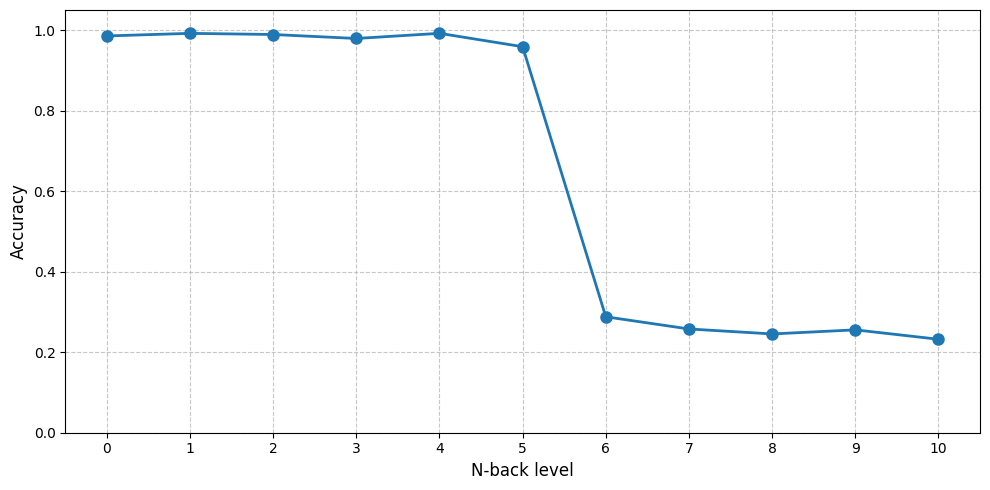

In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import trange
import torch.nn.functional as F

from n_back_spatial_task import (  
    sample_n_back_spatial,
    create_n_back_dataset,
    NBackDataset as ColleagueNBackDataset,
    idx2mov,
    loc2idx,
    idx2loc
)

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)  

#--Configuration--
GRID_SIZE = np.array([5, 5], dtype=int)  
HIDDEN_SIZE = 128
INPUT_SIZE = 4 
OUTPUT_SIZE = GRID_SIZE[0] * GRID_SIZE[1] 
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  
SEQ_LENGTH = 50  
BATCH_SIZE = 100
LEARNING_RATE = 0.0005
EPOCHS = 50
BOUNDARY = 'strict'  


class NBackDataset(ColleagueNBackDataset):  # Inherit from Italo's class
    def __init__(self, num_samples, n_back):
        # Using Italo's create_n_back_dataset function
        dataset = create_n_back_dataset(
            num_samples=num_samples,
            n=n_back,
            max_length=SEQ_LENGTH,
            grid_size=GRID_SIZE,
            boundary=BOUNDARY
        )
        super().__init__(dataset.x, dataset.y)

class NBackLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=4,
            hidden_size=HIDDEN_SIZE,
            num_layers=1,
            batch_first=True
        )
        self.fc = nn.Sequential(
            nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)
        )
        
        self.h0 = nn.Parameter(torch.randn(1, 1, HIDDEN_SIZE) * 0.05)
        self.c0 = nn.Parameter(torch.randn(1, 1, HIDDEN_SIZE) * 0.05)
        
    def forward(self, x, batch_size):
        x = F.one_hot(x, num_classes=4).float().to(DEVICE)
        h0 = self.h0.expand(1, batch_size, -1).contiguous()
        c0 = self.c0.expand(1, batch_size, -1).contiguous()
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out)

class NBackTrainer:
    def __init__(self, n_back):
        self.n_back = n_back
        self.model = NBackLSTM().to(DEVICE)
        self.optimizer = optim.AdamW(self.model.parameters(), lr=LEARNING_RATE)
        self.criterion = nn.CrossEntropyLoss()
        
    def train(self, epochs=EPOCHS):
        train_loader = DataLoader(
            NBackDataset(10_000, self.n_back),
            batch_size=BATCH_SIZE,
            shuffle=True
        )
        
        self.model.train()
        for epoch in trange(epochs, desc=f"Training N={self.n_back}"):
            total_loss = 0
            for actions, targets in train_loader:
                actions, targets = actions.to(DEVICE), targets.to(DEVICE)
                batch_size = actions.size(0)
                
                self.optimizer.zero_grad()
                logits = self.model(actions, batch_size)
                
                loss = self.criterion(
                    logits[:, self.n_back:].reshape(-1, OUTPUT_SIZE),  # Predictions from step n onward
                    targets.reshape(-1))  
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optimizer.step()
                total_loss += loss.item()
    
    def evaluate(self, test_samples=1_000):
        test_loader = DataLoader(
            NBackDataset(test_samples, self.n_back),
            batch_size=BATCH_SIZE
        )
        
        self.model.eval()
        correct = total = 0
        with torch.no_grad():
            for actions, targets in test_loader:
                actions, targets = actions.to(DEVICE), targets.to(DEVICE)
                batch_size = actions.size(0)
                logits = self.model(actions, batch_size)
                
                preds = logits[:, self.n_back:].argmax(-1)
                tgts = targets
                
                correct += (preds == tgts).sum().item()
                total += tgts.numel()
                
        return correct / total if total > 0 else 0

def run_experiment(max_n=10):
    accuracies = []
    for N in range(max_n + 1):
        print(f"\n=== Training N={N} ===")
        trainer = NBackTrainer(N)
        trainer.train()
        
        # Evaluate 3 times for stability
        eval_acc = np.mean([trainer.evaluate() for _ in range(3)])
        accuracies.append(eval_acc)
        print(f"N={N} Final Accuracy: {eval_acc:.4f}")
        
    return accuracies

# Run experiment
accuracies = run_experiment()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(range(len(accuracies)), accuracies, marker='o', linewidth=2, markersize=8)
plt.xlabel("N-back level", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(range(len(accuracies)))
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()